# Imports

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX
import warnings
warnings.filterwarnings("ignore")

## Trabalhando dados do Excel

Carregando Arquivo xlsx

In [26]:
df = pd.read_excel('laudos_piloto002.xlsx')

Separando colunas para apagar

In [27]:
colunas_para_apagar = ['Nome do Paciente', 'Posicionamentos', 'Laudo','Imagens','Nome do Tutor', 'Regiao', 'Todos Exames', 'Numero de Projeções', 'lista de imagens', 'quantidade de imagens', 'Laudo Alterado', 'Exames Separados', 'Idade (meses)', 'Primeira Região','Segunda Região', 'Terceira Região', 'Quarta Região', 'regiao_corpo','regiao_corpo_str']

In [28]:
df = df.drop(columns=colunas_para_apagar)

Organizando Espécies

In [29]:
df['Espécie'] = df['Espécie'].replace(
    ['AVE', 'QUELONIO', 'QUILONIO'], 
    'SILVESTRE'
)

In [30]:
df['Espécie'] = df['Espécie'].replace(
    ['CAINO'], 
    'CANINO'
)

Formatando data para estudo

In [31]:
df['Data do Exame'] = pd.to_datetime(df['Data do Exame'], dayfirst=True) 
df['AnoMes'] = df['Data do Exame'].dt.to_period('M').astype(str)


In [32]:
df['AnoMes'] = pd.to_datetime(df['AnoMes'])

# Remover meses de abril (4), maio (5) e junho (6) para teste pois estão faltando dados na planilha
df = df[~df['AnoMes'].dt.month.isin([4, 5, 6])]

# Agrupando e visualizando Número de Exames ao longo do tempo

In [33]:
exames_mensais = df.groupby(['AnoMes', 'Espécie']).size().unstack(fill_value=0)


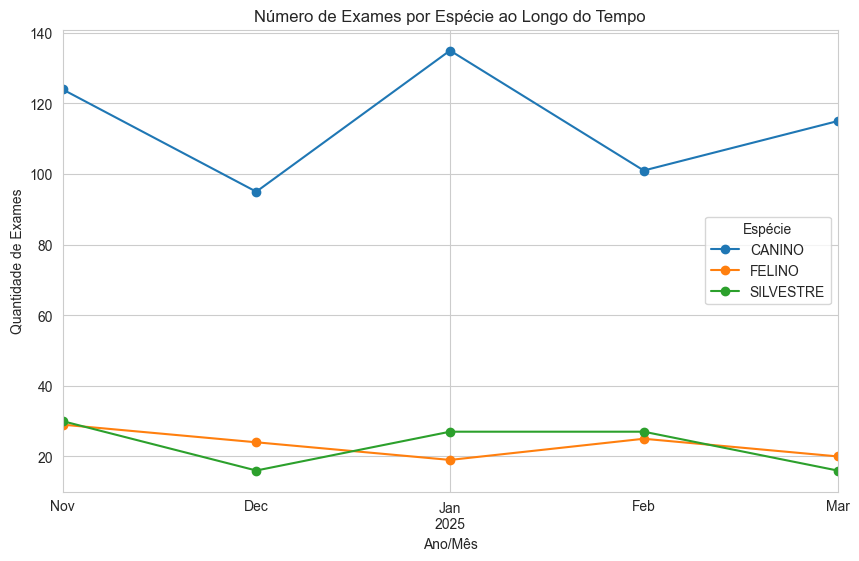

In [34]:
exames_mensais.plot(marker='o', figsize=(10, 6))
plt.title('Número de Exames por Espécie ao Longo do Tempo')
plt.xlabel('Ano/Mês')
plt.ylabel('Quantidade de Exames')
plt.grid(True)
plt.show()

# Criando Previsões 

In [35]:
previsoes = {}

for especie in exames_mensais.columns:
    serie = exames_mensais[especie]
    modelo = SARIMAX(serie, order=(1,1,1), seasonal_order=(1,1,1,12))
    resultado = modelo.fit(disp=False)
    previsao = resultado.forecast(steps=1)
    previsoes[especie] = round(previsao.values[0])

print(previsoes)


{'CANINO': 115, 'FELINO': 20, 'SILVESTRE': 16}


# Visualizando Previsões

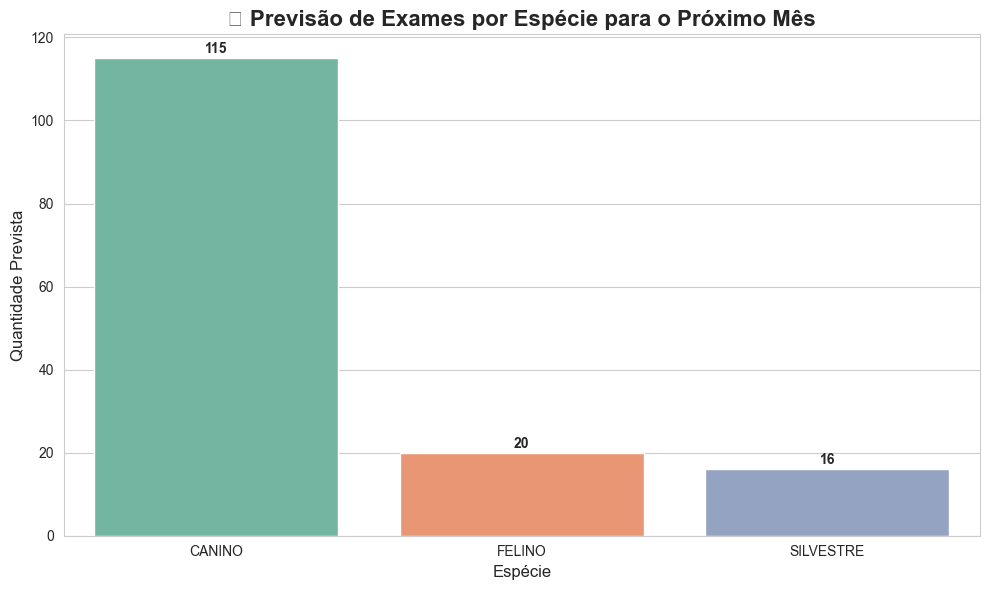

In [36]:
sns.set_style("whitegrid")
especies = list(previsoes.keys())
valores = list(previsoes.values())
plt.figure(figsize=(10, 6))
barplot = sns.barplot(x=especies, y=valores, palette="Set2")
plt.title('📈 Previsão de Exames por Espécie para o Próximo Mês', fontsize=16, weight='bold')
plt.xlabel('Espécie', fontsize=12)
plt.ylabel('Quantidade Prevista', fontsize=12)

for i, valor in enumerate(valores):
    plt.text(i, valor + 0.5, str(valor), ha='center', va='bottom', fontsize=10, weight='bold')

plt.tight_layout()
plt.show()
